In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [4]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        images = images.astype('float32') / 255
        images_mean = np.mean(images, axis=0)
        images -= images_mean

        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [5]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [6]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):

  """
  p : the probability that random erasing is performed
  s_l, s_h : minimum / maximum proportion of erased area against input image
  r_1, r_2 : minimum / maximum aspect ratio of erased area
  v_l, v_h : minimum / maximum value for erased area
  pixel_level : pixel-level randomization for erased area
  """

  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser

In [7]:

aug = ImageDataGenerator(
# set input mean to 0 over the dataset
        
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        #Cutout Implementation
        preprocessing_function=get_random_eraser(p=0.1,v_l=0, v_h=0.5, s_l=0.008, s_h=0.05, pixel_level=False)
        # image data format, either "channels_first" or "channels_last"
       )

In [8]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [9]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [10]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten
from keras.utils import plot_model
import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [11]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [12]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
____________________________________________________________________________________________

__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 1024)         0           avg_pool_5_3x3/1[0][0]           
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          524800      dropout_3[0][0]                  
Total params: 6,498,352
Trainable params: 6,498,352
Non-trainable params: 0
__________________________________________________________________________________________________
None


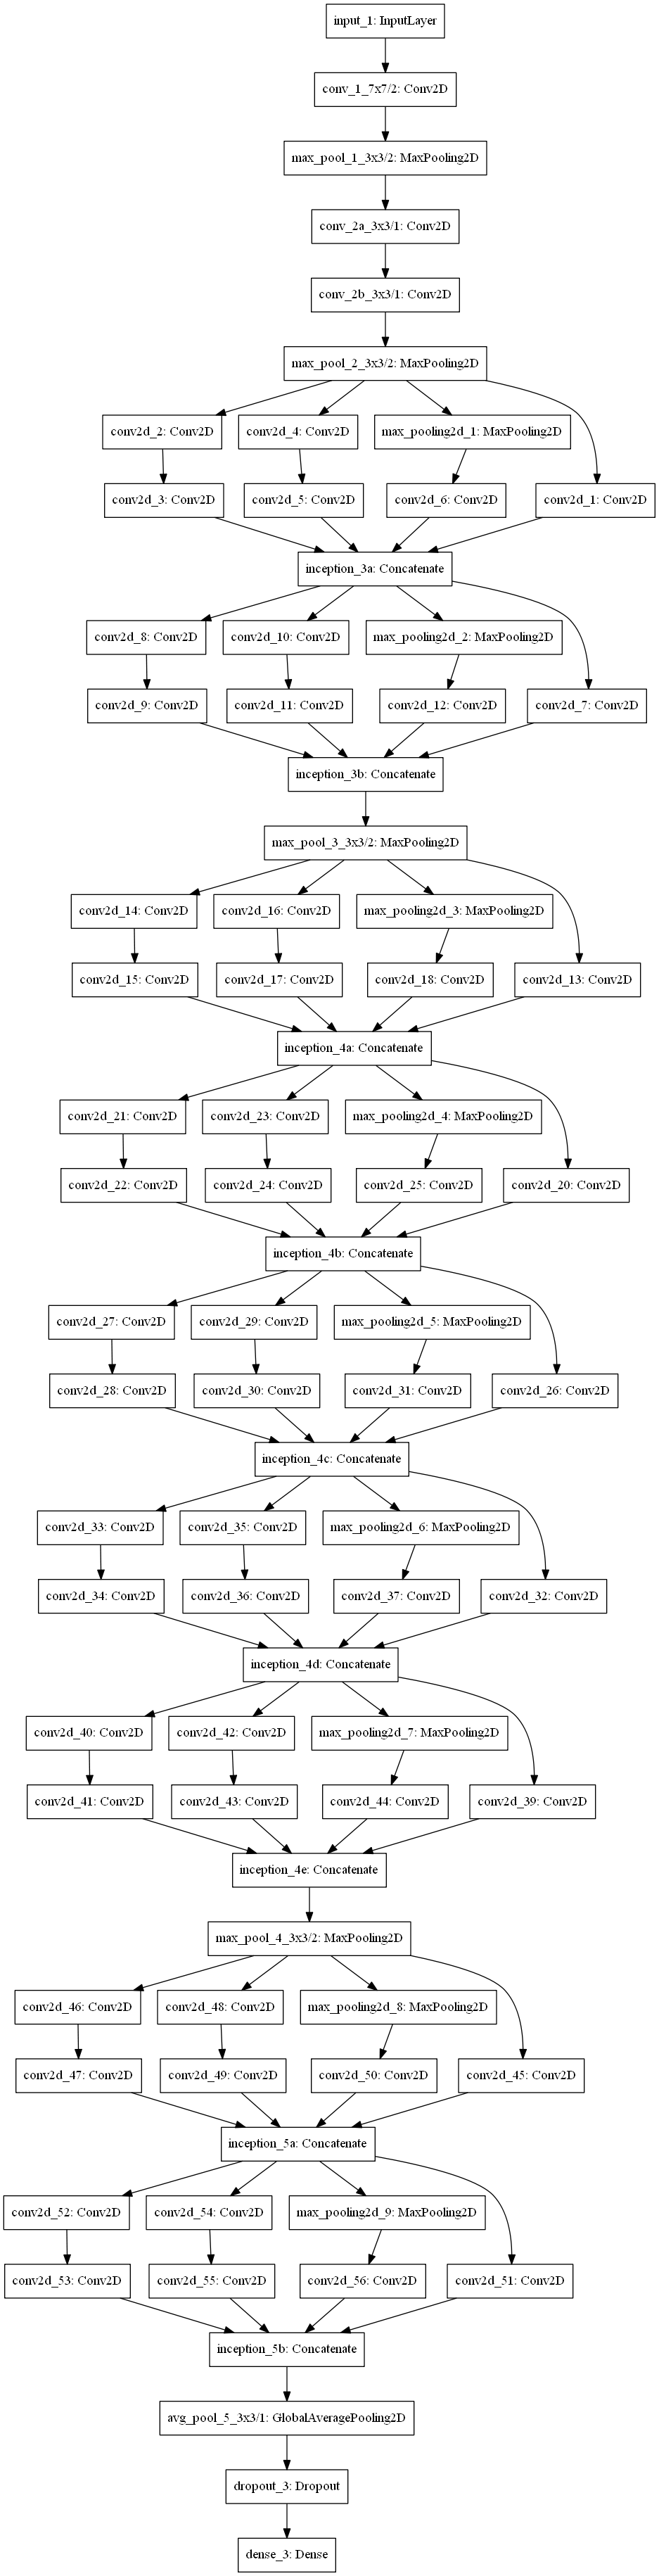

In [13]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

output = Dense(512, activation='softmax')(x)


backbone = Model(inputs=input_layer, outputs=output)
print(backbone.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(backbone, to_file='convolutional_neural_network.png')

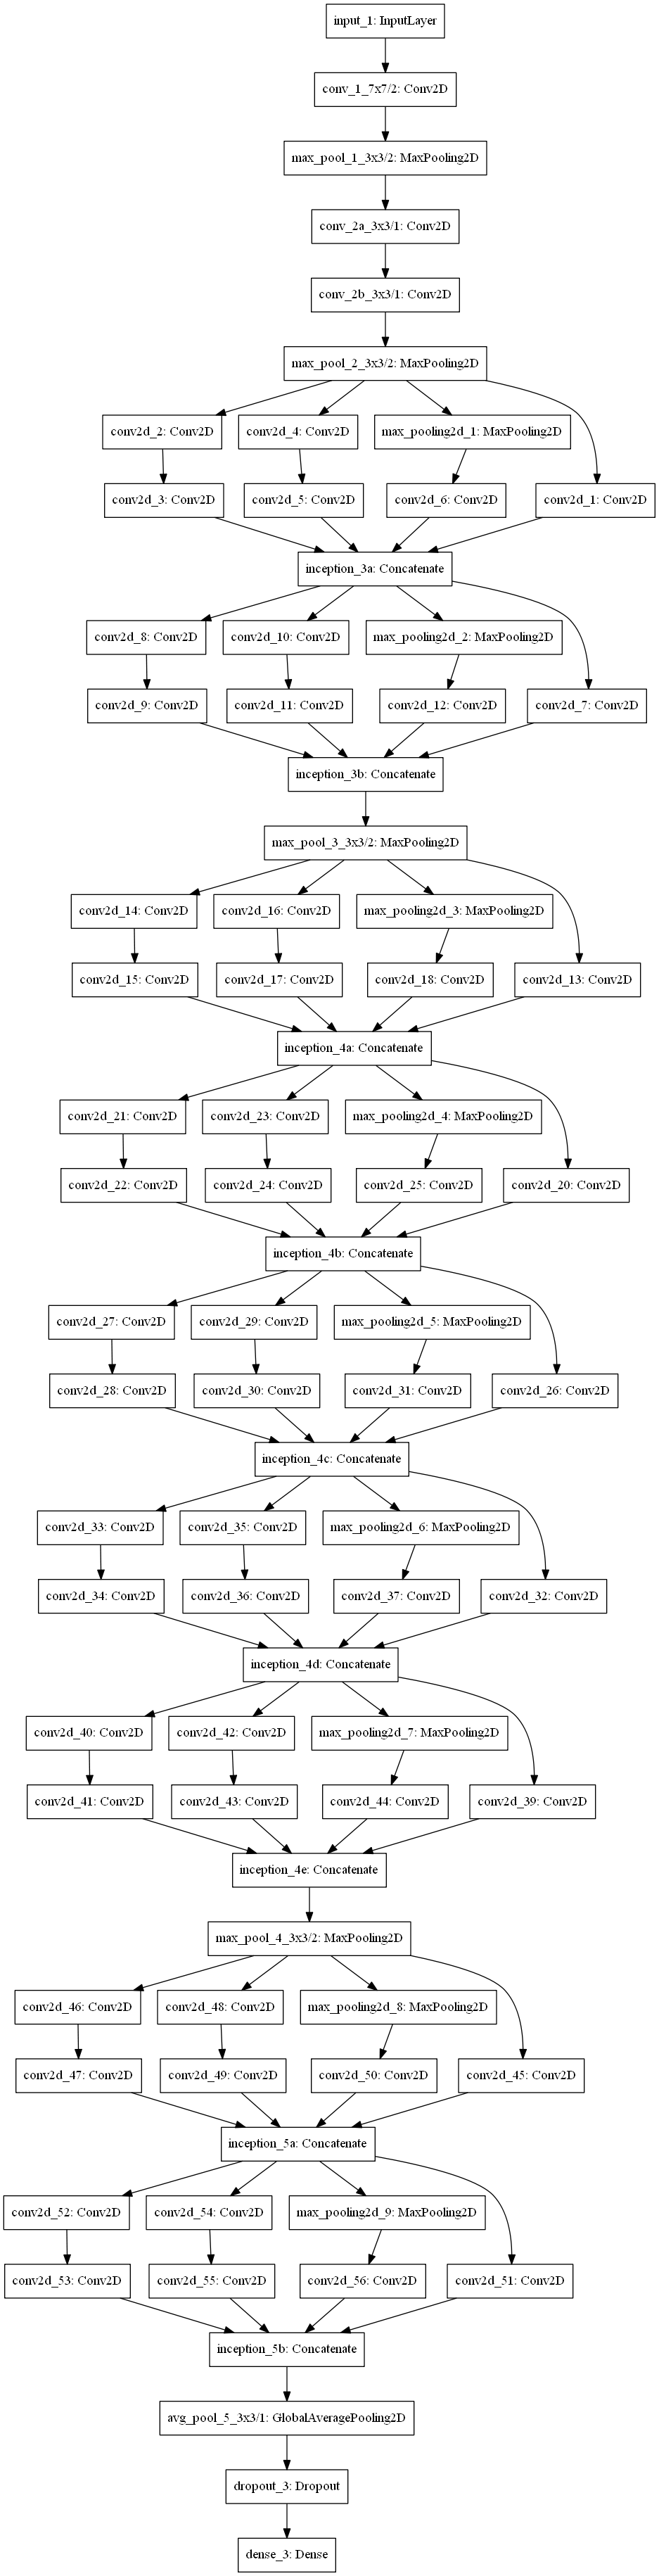

In [14]:

neck = backbone.output

neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


Dhruv_net = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(backbone, to_file='convolutional_neural_network.png')

In [15]:
class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [16]:
#define custom losses 


losses = {
"gender_output": "binary_crossentropy",
"image_quality_output": "categorical_crossentropy",
"age_output": "categorical_crossentropy",
"weight_output": "categorical_crossentropy",
"bag_output": "categorical_crossentropy",
"pose_output": "categorical_crossentropy",
"footwear_output": "categorical_crossentropy",
"emotion_output": "categorical_crossentropy"

}

In [17]:
opt = SGD(lr=0.001, momentum=0.9)
Dhruv_net.compile(
    optimizer=opt,
    loss=losses, 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [18]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('D:/Assignment 6/keras_one_cycle_clr-master/keras_one_cycle_clr')

In [19]:
sys.path

['c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\python36.zip',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\DLLs',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36',
 '',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\win32\\lib',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\Pythonwin',
 'c:\\users\\ddr2kor\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\ddr2kor\\.ipython',
 'D:/Assignment 6/keras_one_cycle_clr-master/keras_one_cycle_clr']

In [20]:
from lr_range_test import LrRangeTest
from utils import *
from cyclic_lr import *
from one_cycle import *


In [21]:
batch_size=64

In [ ]:

lrrf_cb = LrRangeTest(lr_range = (1e-6, 1),
                 wd_list = [5e-4],  # grid search for weight decay
                 steps=100,
                 batches_per_step=5,
                 threshold_multiplier=5.0,
                 validation_data=None,
                 batches_per_val = 5,
                 verbose=True)
n_epoch = 1
Dhruv_net.fit_generator(generator=train_gen, verbose=1,
          epochs=n_epoch,
          validation_data=None,
          callbacks=[lrrf_cb])
lrrf_cb.plot()

In [ ]:
clr_cb = ktool.CLR(cyc=3,
                   lr_range=(1e-2/5, 1e-2),
                   momentum_range=(0.95, 0.85),
                   verbose=False,
                   amplitude_fn=lambda x: np.power(1.0/3, x))

clr_cb.test_run(600) # see that a new cycle starts at 0th, 200th, and 400th iteration.

In [ ]:
clr_hist = Dhruv_net.fit(x_train, y_train,
                     epochs=60,
                     validation_data=(x_test, y_test),
                     verbose=2,
                     callbacks=[clr_cb])

plot_from_history(clr_hist)

In [22]:
epochs = 200
max_lr = 0.001
base_lr = max_lr/100
max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 8

iterations = round(len(train_df)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)


clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

import os
from keras import backend as K
# Prepare model model saving directory.
save_dir = 'D:\Assignment 6\saved_models\\'
model_name = 'Dhruv_Net Inception Faster Convergence.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)


# Prepare callbacks for model saving and for learning rate adjustment.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=filepath,
                             #monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

callbacks = [clr, checkpoint]

D:\Assignment 6\saved_models\Dhruv_Net Inception Faster Convergence.h5


In [23]:

# Run training, with or without data augmentation.
Dhruv_net.fit_generator(
          generator=train_gen,
          validation_data=valid_gen,

          epochs=200,

          #shuffle=True,
          callbacks=callbacks)

Epoch 1/200
360/360 [==============================] - 1245s 3s/step - loss: 9.1193 - gender_output_loss: 0.6908 - image_quality_output_loss: 1.0724 - age_output_loss: 1.5823 - weight_output_loss: 1.3071 - bag_output_loss: 1.0617 - footwear_output_loss: 1.0847 - pose_output_loss: 1.0512 - emotion_output_loss: 1.2690 - gender_output_accuracy: 0.5577 - image_quality_output_accuracy: 0.5102 - age_output_accuracy: 0.3807 - weight_output_accuracy: 0.5907 - bag_output_accuracy: 0.5240 - footwear_output_accuracy: 0.4282 - pose_output_accuracy: 0.6175 - emotion_output_accuracy: 0.6806 - val_loss: 8.5232 - val_gender_output_loss: 0.6874 - val_image_quality_output_loss: 1.0296 - val_age_output_loss: 1.5355 - val_weight_output_loss: 1.1752 - val_bag_output_loss: 1.0022 - val_footwear_output_loss: 1.0626 - val_pose_output_loss: 0.9830 - val_emotion_output_loss: 1.0764 - val_gender_output_accuracy: 0.5628 - val_image_quality_output_accuracy: 0.5522 - val_age_output_accuracy: 0.3992 - val_weight_out


Epoch 00007: val_loss did not improve from 7.89316
Epoch 8/200
360/360 [==============================] - 1187s 3s/step - loss: 7.8823 - gender_output_loss: 0.6852 - image_quality_output_loss: 0.9823 - age_output_loss: 1.4278 - weight_output_loss: 0.9888 - bag_output_loss: 0.9211 - footwear_output_loss: 1.0385 - pose_output_loss: 0.9274 - emotion_output_loss: 0.9112 - gender_output_accuracy: 0.5629 - image_quality_output_accuracy: 0.5524 - age_output_accuracy: 0.3987 - weight_output_accuracy: 0.6338 - bag_output_accuracy: 0.5611 - footwear_output_accuracy: 0.4470 - pose_output_accuracy: 0.6174 - emotion_output_accuracy: 0.7095 - val_loss: 7.9155 - val_gender_output_loss: 0.6853 - val_image_quality_output_loss: 0.9820 - val_age_output_loss: 1.4270 - val_weight_output_loss: 0.9878 - val_bag_output_loss: 0.9204 - val_footwear_output_loss: 1.0378 - val_pose_output_loss: 0.9265 - val_emotion_output_loss: 0.9111 - val_gender_output_accuracy: 0.5628 - val_image_quality_output_accuracy: 0.552


Epoch 00014: val_loss did not improve from 7.89316
Epoch 15/200
360/360 [==============================] - 1178s 3s/step - loss: 7.8836 - gender_output_loss: 0.6857 - image_quality_output_loss: 0.9823 - age_output_loss: 1.4278 - weight_output_loss: 0.9891 - bag_output_loss: 0.9208 - footwear_output_loss: 1.0386 - pose_output_loss: 0.9272 - emotion_output_loss: 0.9121 - gender_output_accuracy: 0.5628 - image_quality_output_accuracy: 0.5527 - age_output_accuracy: 0.3988 - weight_output_accuracy: 0.6336 - bag_output_accuracy: 0.5609 - footwear_output_accuracy: 0.4469 - pose_output_accuracy: 0.6174 - emotion_output_accuracy: 0.7091 - val_loss: 7.9168 - val_gender_output_loss: 0.6852 - val_image_quality_output_loss: 0.9819 - val_age_output_loss: 1.4270 - val_weight_output_loss: 0.9878 - val_bag_output_loss: 0.9204 - val_footwear_output_loss: 1.0379 - val_pose_output_loss: 0.9265 - val_emotion_output_loss: 0.9112 - val_gender_output_accuracy: 0.5628 - val_image_quality_output_accuracy: 0.55


Epoch 00021: val_loss did not improve from 7.89316
Epoch 22/200
360/360 [==============================] - 1184s 3s/step - loss: 7.8821 - gender_output_loss: 0.6853 - image_quality_output_loss: 0.9823 - age_output_loss: 1.4283 - weight_output_loss: 0.9885 - bag_output_loss: 0.9210 - footwear_output_loss: 1.0385 - pose_output_loss: 0.9270 - emotion_output_loss: 0.9111 - gender_output_accuracy: 0.5629 - image_quality_output_accuracy: 0.5523 - age_output_accuracy: 0.3984 - weight_output_accuracy: 0.6339 - bag_output_accuracy: 0.5607 - footwear_output_accuracy: 0.4469 - pose_output_accuracy: 0.6175 - emotion_output_accuracy: 0.7093 - val_loss: 7.9133 - val_gender_output_loss: 0.6853 - val_image_quality_output_loss: 0.9819 - val_age_output_loss: 1.4270 - val_weight_output_loss: 0.9878 - val_bag_output_loss: 0.9204 - val_footwear_output_loss: 1.0379 - val_pose_output_loss: 0.9265 - val_emotion_output_loss: 0.9113 - val_gender_output_accuracy: 0.5628 - val_image_quality_output_accuracy: 0.55

KeyboardInterrupt: 